## Importing Required Libraries

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense, Reshape, RepeatVector, Dropout
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
from keras.constraints import unit_norm, max_norm
import tensorflow as tf
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import argparse
import os
from sklearn.manifold import MDS
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error, r2_score

In [23]:
from tensorflow.keras.layers import Input, Dense, Lambda, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mse
import tensorflow as tf

## Reparameterization Trick Function

In [24]:
from mpl_toolkits.mplot3d import Axes3D

# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    thre = K.random_uniform(shape=(batch,1))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

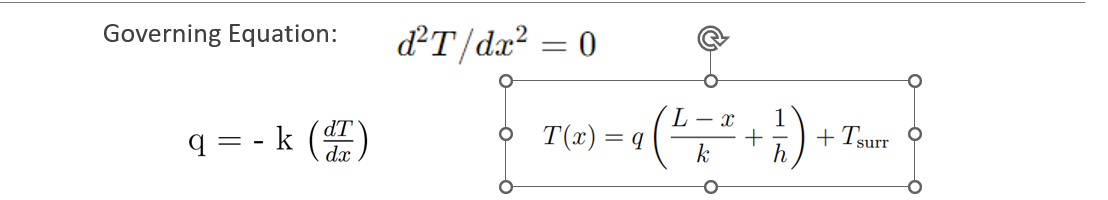

In [25]:
from IPython.display import Image, display

# Adjust the path below to the path of your image in Google Drive
image_path = '/content/drive/MyDrive/MTP_FINAL/image_2.png'

display(Image(filename=image_path))

##Dataset for Two parameter estimation is generated using above equation where we consider different random values of k and q and these are also the parameters to be estimated and we get temperature values at 11 different points along the length of slab

## Importing the Dataset

In [26]:
import csv
import numpy as np

# Constants
h = 12.5
L = 1
Tsurr = 298
l_values = np.arange(0, 1.1, 0.1)

# Function to calculate T(l)
def calculate_T(l, q, k, h, L, Tsurr):
    return q * ((L - l) / k + 1 / h) + Tsurr

# Generate 1000 rows of data
data = []

for _ in range(1000):
    q = np.random.uniform(1000, 1100)
    k = np.random.uniform(10, 200)
    q_std = 0.05 * q
    k_std = 0.05 * k
    q_log_var = np.log(q_std ** 2)
    k_log_var = np.log(k_std ** 2)
    row = [calculate_T(l, q, k, h, L, Tsurr) for l in l_values]
    row.extend([q, k, q_log_var, k_log_var])
    data.append(row)

# Column names
columns = [f'x{i+1}' for i in range(len(l_values))]
columns.extend(['q', 'k', 'q_log_var', 'k_log_var'])

# Write data to CSV file
with open('Temp_data2parameter.csv', 'w', newline='') as f:
    writer = csv.writer(f)

    # Write the column headers
    writer.writerow(columns)

    # Write the data rows
    writer.writerows(data)

print("Data written to Temp_data2parameter.csv")

Data written to Temp_data2parameter.csv


In [27]:
from tensorflow.keras.models import load_model
import pandas as pd
import numpy as np

data = pd.read_csv('/content/Temp_data2parameter.csv')
data = pd.DataFrame(data)
data.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,q,k,q_log_var,k_log_var
0,388.197510,387.541925,386.886340,386.230755,385.575169,384.919584,384.263999,383.608413,382.952828,382.297243,381.641658,1045.520720,159.478980,7.913076,4.152360
1,391.135396,390.563534,389.991671,389.419809,388.847946,388.276084,387.704221,387.132359,386.560496,385.988634,385.416771,1092.709644,191.079100,8.001367,4.513910
2,412.975310,409.828393,406.681476,403.534559,400.387642,397.240725,394.093808,390.946891,387.799974,384.653057,381.506140,1043.826747,33.169821,7.909833,1.011816
3,389.976936,389.226470,388.476005,387.725539,386.975073,386.224608,385.474142,384.723676,383.973211,383.222745,382.472279,1055.903491,140.699775,7.932840,3.901792
4,399.439614,397.882205,396.324797,394.767389,393.209981,391.652573,390.095165,388.537756,386.980348,385.422940,383.865532,1073.319149,68.917011,7.965558,2.474342


In [28]:
data.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,q,k,q_log_var,k_log_var
0,388.197510,387.541925,386.886340,386.230755,385.575169,384.919584,384.263999,383.608413,382.952828,382.297243,381.641658,1045.520720,159.478980,7.913076,4.152360
1,391.135396,390.563534,389.991671,389.419809,388.847946,388.276084,387.704221,387.132359,386.560496,385.988634,385.416771,1092.709644,191.079100,8.001367,4.513910
2,412.975310,409.828393,406.681476,403.534559,400.387642,397.240725,394.093808,390.946891,387.799974,384.653057,381.506140,1043.826747,33.169821,7.909833,1.011816
3,389.976936,389.226470,388.476005,387.725539,386.975073,386.224608,385.474142,384.723676,383.973211,383.222745,382.472279,1055.903491,140.699775,7.932840,3.901792
4,399.439614,397.882205,396.324797,394.767389,393.209981,391.652573,390.095165,388.537756,386.980348,385.422940,383.865532,1073.319149,68.917011,7.965558,2.474342


In [29]:
y_original = data[['q','k']]
y_original.head()

,q,k
0,1045.520720,159.478980
1,1092.709644,191.079100
2,1043.826747,33.169821
3,1055.903491,140.699775
4,1073.319149,68.917011


In [30]:
y_log_var_prior = data[['q_log_var','k_log_var']]
y_log_var_prior.head()

,q_log_var,k_log_var
0,7.913076,4.152360
1,8.001367,4.513910
2,7.909833,1.011816
3,7.932840,3.901792
4,7.965558,2.474342


## Original Data without Noise

In [31]:
original_data_without_noise = data.iloc[:,:-4]
original_data_without_noise.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11
0,388.197510,387.541925,386.886340,386.230755,385.575169,384.919584,384.263999,383.608413,382.952828,382.297243,381.641658
1,391.135396,390.563534,389.991671,389.419809,388.847946,388.276084,387.704221,387.132359,386.560496,385.988634,385.416771
2,412.975310,409.828393,406.681476,403.534559,400.387642,397.240725,394.093808,390.946891,387.799974,384.653057,381.506140
3,389.976936,389.226470,388.476005,387.725539,386.975073,386.224608,385.474142,384.723676,383.973211,383.222745,382.472279
4,399.439614,397.882205,396.324797,394.767389,393.209981,391.652573,390.095165,388.537756,386.980348,385.422940,383.865532


## Adding Noise in the dataset (In the independent features/Temperature Distribution)

In [32]:
# Percentage of the standard deviation to be used for noise
percentage_std = 5 / 100

# Calculate standard deviations for each column
std_devs = original_data_without_noise.std()

# Generate noise for each element based on 5% of the column's standard deviation
noise = pd.DataFrame()
for column in original_data_without_noise.columns:
    column_noise = np.random.normal(0, std_devs[column] * percentage_std, size=original_data_without_noise.shape[0])
    noise[column] = column_noise

# Add the noise to the original data
original_data_with_noise = original_data_without_noise + noise

# Show the modified DataFrame
print(original_data_with_noise.head())

           x1          x2          x3          x4          x5          x6  \
0  388.380139  386.746747  385.461090  387.403742  385.775226  384.924377   
1  392.049880  389.264086  389.825690  389.196256  388.462539  387.658609   
2  412.705508  409.281988  407.293490  403.460187  400.844328  397.918282   
3  389.896628  388.462193  389.037116  387.818627  386.752608  385.660579   
4  399.845265  397.329910  396.333357  395.825482  391.881047  391.063555   

           x7          x8          x9         x10         x11  
0  384.107986  383.966903  382.863456  382.471810  381.688265  
1  388.715251  387.451631  385.919039  385.719910  385.379216  
2  393.299890  390.561048  387.775308  384.708637  381.454614  
3  385.798723  384.626991  383.732390  383.017437  382.540006  
4  389.319457  388.441699  386.988623  385.470499  383.894640  


## Combined Dataset

In [33]:
data_without_noise = pd.concat([original_data_without_noise, data.iloc[:,[-4,-3,-2,-1]]], axis=1)
print(data_without_noise)

             x1          x2          x3          x4          x5          x6  \
0    388.197510  387.541925  386.886340  386.230755  385.575169  384.919584   
1    391.135396  390.563534  389.991671  389.419809  388.847946  388.276084   
2    412.975310  409.828393  406.681476  403.534559  400.387642  397.240725   
3    389.976936  389.226470  388.476005  387.725539  386.975073  386.224608   
4    399.439614  397.882205  396.324797  394.767389  393.209981  391.652573   
..          ...         ...         ...         ...         ...         ...   
995  388.895556  388.163990  387.432424  386.700859  385.969293  385.237727   
996  389.991816  388.974272  387.956729  386.939185  385.921641  384.904097   
997  386.771799  386.175343  385.578887  384.982431  384.385975  383.789519   
998  389.319455  388.523863  387.728270  386.932678  386.137086  385.341493   
999  401.752126  399.936623  398.121120  396.305618  394.490115  392.674612   

             x7          x8          x9         x10

In [34]:
data = pd.concat([original_data_with_noise, data.iloc[:,[-4,-3,-2,-1]]], axis=1)
print(data)

             x1          x2          x3          x4          x5          x6  \
0    388.380139  386.746747  385.461090  387.403742  385.775226  384.924377   
1    392.049880  389.264086  389.825690  389.196256  388.462539  387.658609   
2    412.705508  409.281988  407.293490  403.460187  400.844328  397.918282   
3    389.896628  388.462193  389.037116  387.818627  386.752608  385.660579   
4    399.845265  397.329910  396.333357  395.825482  391.881047  391.063555   
..          ...         ...         ...         ...         ...         ...   
995  388.268049  388.625621  387.192025  387.388327  386.215756  385.668412   
996  390.989791  388.232891  388.445496  387.987054  386.086924  385.109146   
997  387.039138  386.645614  386.367455  385.568371  385.177994  383.931057   
998  388.235290  388.221382  387.713377  386.756594  385.225132  385.025300   
999  402.575056  400.322116  398.283345  395.900623  394.404410  393.189983   

             x7          x8          x9         x10

In [35]:
std_devs

x1     18.964872
x2     17.112762
x3     15.264408
x4     13.421361
x5     11.586153
x6      9.763207
x7      7.960951
x8      6.197461
x9      4.518357
x10     3.065588
x11     2.314164
dtype: float64

In [36]:
noise

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11
0,0.182628,-0.795178,-1.425250,1.172987,0.200057,0.004793,-0.156013,0.358490,-0.089372,0.174567,0.046607
1,0.914484,-1.299447,-0.165981,-0.223552,-0.385408,-0.617474,1.011029,0.319272,-0.641457,-0.268724,-0.037555
2,-0.269801,-0.546404,0.612015,-0.074372,0.456686,0.677558,-0.793918,-0.385843,-0.024666,0.055580,-0.051526
3,-0.080308,-0.764277,0.561112,0.093088,-0.222465,-0.564029,0.324581,-0.096686,-0.240820,-0.205308,0.067727
4,0.405651,-0.552295,0.008560,1.058093,-1.328934,-0.589018,-0.775707,-0.096058,0.008275,0.047559,0.029108
...,...,...,...,...,...,...,...,...,...,...,...
995,-0.627507,0.461631,-0.240400,0.687468,0.246463,0.430686,-0.564558,-0.014236,-0.103084,0.190232,-0.008390
996,0.997974,-0.741381,0.488768,1.047869,0.165283,0.205050,0.792781,0.465738,-0.431157,-0.063932,0.043190
997,0.267339,0.470271,0.788568,0.585940,0.792019,0.141538,0.163067,0.566166,-0.047895,0.082842,-0.001393
998,-1.084165,-0.302481,-0.014894,-0.176085,-0.911954,-0.316193,-0.227449,0.110193,0.159457,-0.185052,0.207799


In [37]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

def standardize_and_store_params(df):
    scaler = StandardScaler()
    standardized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

    # Storing means and scales (standard deviations)
    params = {
        'mean': scaler.mean_,
        'scale': scaler.scale_
    }
    return standardized_df, params

# Standardizing and storing parameters
standardized_df, params = standardize_and_store_params(data)
print("Standardized DataFrame:")
print(standardized_df)
print("\nStored Parameters:")
print(params)

Standardized DataFrame:
           x1        x2        x3        x4        x5        x6        x7  \
0   -0.610445 -0.665946 -0.712671 -0.530777 -0.602037 -0.620151 -0.638603   
1   -0.417003 -0.519369 -0.427088 -0.397201 -0.370599 -0.340383 -0.060171   
2    0.671815  0.646210  0.715855  0.665731  0.695753  0.709392  0.515419   
3   -0.530507 -0.566061 -0.478686 -0.499860 -0.517863 -0.544822 -0.426335   
4   -0.006085 -0.049722 -0.001282  0.096801 -0.076188  0.008013  0.015685   
..        ...       ...       ...       ...       ...       ...       ...   
995 -0.616354 -0.556545 -0.599413 -0.531926 -0.564098 -0.544021 -0.659492   
996 -0.472883 -0.579412 -0.517397 -0.487309 -0.575193 -0.601245 -0.566871   
997 -0.681133 -0.671835 -0.653366 -0.667547 -0.653473 -0.721788 -0.732997   
998 -0.618081 -0.580083 -0.565300 -0.579002 -0.649413 -0.609824 -0.612179   
999  0.137810  0.124505  0.126308  0.102401  0.141131  0.225590  0.271968   

           x8        x9       x10       x11        

## Normalizing the dataframe

In [38]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Create a MinMaxScaler instance
scaler = StandardScaler()

# Assuming 'data' is your original DataFrame you want to normalize
# Normalize the DataFrame and create a new DataFrame
normalized_data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

print("\nNormalized DataFrame using StandardScaler:")
print(normalized_data)


Normalized DataFrame using StandardScaler:
           x1        x2        x3        x4        x5        x6        x7  \
0   -0.610445 -0.665946 -0.712671 -0.530777 -0.602037 -0.620151 -0.638603   
1   -0.417003 -0.519369 -0.427088 -0.397201 -0.370599 -0.340383 -0.060171   
2    0.671815  0.646210  0.715855  0.665731  0.695753  0.709392  0.515419   
3   -0.530507 -0.566061 -0.478686 -0.499860 -0.517863 -0.544822 -0.426335   
4   -0.006085 -0.049722 -0.001282  0.096801 -0.076188  0.008013  0.015685   
..        ...       ...       ...       ...       ...       ...       ...   
995 -0.616354 -0.556545 -0.599413 -0.531926 -0.564098 -0.544021 -0.659492   
996 -0.472883 -0.579412 -0.517397 -0.487309 -0.575193 -0.601245 -0.566871   
997 -0.681133 -0.671835 -0.653366 -0.667547 -0.653473 -0.721788 -0.732997   
998 -0.618081 -0.580083 -0.565300 -0.579002 -0.649413 -0.609824 -0.612179   
999  0.137810  0.124505  0.126308  0.102401  0.141131  0.225590  0.271968   

           x8        x9       x

In [39]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Create a MinMaxScaler instance
scaler2 = StandardScaler()

# Assuming 'data' is your original DataFrame you want to normalize
# Normalize the DataFrame and create a new DataFrame
normalized_data_without_noise = pd.DataFrame(scaler2.fit_transform(data_without_noise), columns=data.columns)

print("\nNormalized DataFrame using MinMaxScaler:")
print(normalized_data_without_noise)


Normalized DataFrame using MinMaxScaler:
           x1        x2        x3        x4        x5        x6        x7  \
0   -0.619219 -0.619797 -0.620363 -0.620839 -0.621045 -0.620550 -0.618215   
1   -0.464230 -0.443138 -0.416825 -0.383109 -0.338431 -0.276587 -0.185862   
2    0.687945  0.683185  0.677103  0.669080  0.658058  0.642079  0.617156   
3   -0.525345 -0.521310 -0.516169 -0.509409 -0.500159 -0.486815 -0.466129   
4   -0.026137 -0.015251 -0.001722  0.015528  0.038244  0.069424  0.114622   
..        ...       ...       ...       ...       ...       ...       ...   
995 -0.582394 -0.583428 -0.584570 -0.585794 -0.587012 -0.587947 -0.587781   
996 -0.524560 -0.536055 -0.550204 -0.568028 -0.591126 -0.622137 -0.665651   
997 -0.694433 -0.699695 -0.706059 -0.713895 -0.723736 -0.736355 -0.752806   
998 -0.560031 -0.562388 -0.565179 -0.568513 -0.572522 -0.577314 -0.582787   
999  0.095861  0.104861  0.116017  0.130196  0.148788  0.174159  0.210632   

           x8        x9       x10

## Dividing the dataset into Independent and Dependent Features

In [40]:
x = normalized_data.iloc[:,:-4]
x.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11
0,-0.610445,-0.665946,-0.712671,-0.530777,-0.602037,-0.620151,-0.638603,-0.553825,-0.602409,-0.435461,-0.140851
1,-0.417003,-0.519369,-0.427088,-0.397201,-0.370599,-0.340383,-0.060171,0.010702,0.073296,0.623840,1.453131
2,0.671815,0.646210,0.715855,0.665731,0.695753,0.709392,0.515419,0.514428,0.483787,0.294034,-0.241756
3,-0.530507,-0.566061,-0.478686,-0.499860,-0.517863,-0.544822,-0.426335,-0.446891,-0.410255,-0.257516,0.226984
4,-0.006085,-0.049722,-0.001282,0.096801,-0.076188,0.008013,0.015685,0.171093,0.309821,0.542500,0.811999


In [41]:
y = normalized_data.iloc[:,[-4,-3]]
y.head()

,q,k
0,-0.161481,1.022022
1,1.470642,1.587447
2,-0.220071,-1.238045
3,0.197628,0.686003
4,0.799983,-0.598416


In [42]:
log_var = normalized_data.iloc[:,[-2,-1]]
log_var.head()

,q_log_var,k_log_var
0,-0.147886,0.885262
1,1.453774,1.126928
2,-0.206718,-1.213921
3,0.210637,0.717779
4,0.804167,-0.236349


## Independent features without noise

In [43]:
x_without_noise = normalized_data_without_noise.iloc[:,:-4]
x_without_noise.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11
0,-0.619219,-0.619797,-0.620363,-0.620839,-0.621045,-0.620550,-0.618215,-0.610671,-0.585974,-0.492782,-0.161481
1,-0.464230,-0.443138,-0.416825,-0.383109,-0.338431,-0.276587,-0.185862,-0.041775,0.212873,0.711959,1.470642
2,0.687945,0.683185,0.677103,0.669080,0.658058,0.642079,0.617156,0.574032,0.487330,0.276073,-0.220071
3,-0.525345,-0.521310,-0.516169,-0.509409,-0.500159,-0.486815,-0.466129,-0.430626,-0.360030,-0.190731,0.197628
4,-0.026137,-0.015251,-0.001722,0.015528,0.038244,0.069424,0.114622,0.185108,0.305841,0.527336,0.799983


## Train/Test Split

In [44]:
x_train = x.iloc[:800,:]
x_test = x.iloc[800:,:]
x_train.shape, x_test.shape

((800, 11), (200, 11))

In [45]:
y_train = y.iloc[:800,:]
y_test = y.iloc[800:,:]
y_train.shape, y_test.shape

((800, 2), (200, 2))

In [46]:
log_var_train = log_var.iloc[:800,:]
log_var_test = log_var.iloc[800:,:]
log_var_train.shape, log_var_test.shape

((800, 2), (200, 2))

In [47]:
x_train_without_noise = x_without_noise.iloc[:800,:]
x_test_without_noise = x_without_noise.iloc[800:,:]
x_train_without_noise.shape, x_test_without_noise.shape

((800, 11), (200, 11))

In [48]:
training_feature = x_train
training_score = y_train

testing_feature_sk = x_test
testing_score = y_test

original_dim = training_feature.shape[1]
num_train = training_feature.shape[0]

In [49]:
print(original_dim)

11


## Setting the number of layers and neurons in the layers

In [50]:
intermediate_dim_1 = 8
intermediate_dim_2 = 5
intermediate_dim_3 = 3
batch_size = 32
latent_dim = 2
epochs = 1000

## Taking the place holder for inputs

In [51]:
input_shape_x = (original_dim, )
input_shape_r = (latent_dim, )
input_shape_log_var = (latent_dim, )

## Training the Decoder without Noisy Data

In [52]:
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.models import Model

intermediate_dim_1 = 8
intermediate_dim_2 = 5
intermediate_dim_3 = 3
batch_size = 32
latent_dim = 2
epochs = 1000

# Build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
inter_y2 = Dense(intermediate_dim_2, activation='tanh')(latent_inputs)
inter_y3 = Dense(intermediate_dim_1, activation='tanh')(inter_y2)
outputs = Dense(original_dim)(inter_y3)

In [53]:
# Instantiate decoder model
physics_informed_decoder = Model(latent_inputs, outputs, name='physics_informed_decoder')

# Model summary
physics_informed_decoder.summary()

Model: "physics_informed_decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 5)                 15        
                                                                 
 dense_1 (Dense)             (None, 8)                 48        
                                                                 
 dense_2 (Dense)             (None, 11)                99        
                                                                 
Total params: 162 (648.00 Byte)
Trainable params: 162 (648.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/1000
25/25 [==============================] - 1s 13ms/step - loss: 0.9572 - val_loss: 0.5022
Epoch 2/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.5970 - val_loss: 0.3323
Epoch 3/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.2957

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 0s 6ms/step - loss: 0.4575 - val_loss: 0.2595
Epoch 4/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.3847 - val_loss: 0.2225
Epoch 5/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.3358 - val_loss: 0.1929
Epoch 6/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.2914 - val_loss: 0.1617
Epoch 7/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.2535 - val_loss: 0.1406
Epoch 8/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.2163 - val_loss: 0.1136
Epoch 9/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.1847 - val_loss: 0.0975
Epoch 10/1000
25/25 [==============================] - 0s 6ms/step - loss: 0.1589 - val_loss: 0.0802
Epoch 11/1000
25/25 [==============================] - 0s 6ms/step - loss: 0.1390 - val_loss: 0.0708
Epoch 12/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.1220 - val_loss: 0.0588
Epoch 13/1

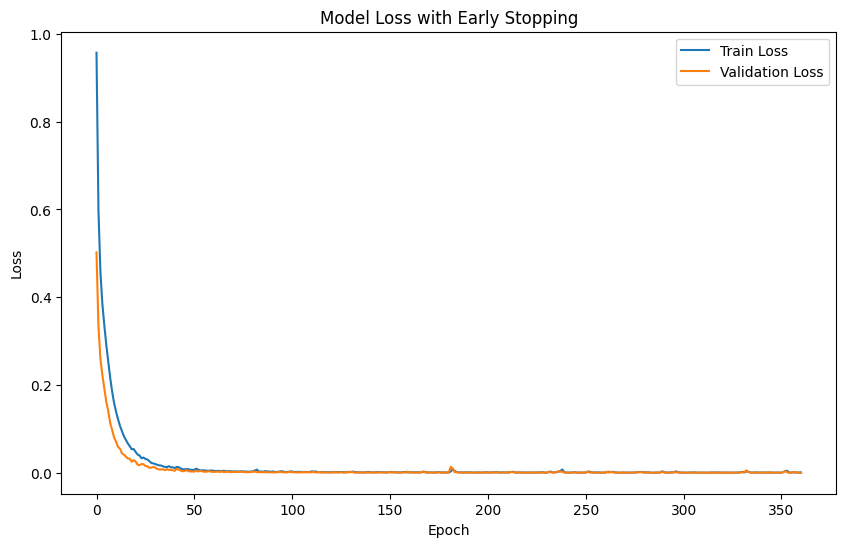

In [54]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import matplotlib.pyplot as plt

# Assuming 'physics_informed_decoder' is your model
model = physics_informed_decoder

# Use Adam optimizer with the specified learning rate
adam_optimizer = Adam(learning_rate=0.005)

# Compile the model with MSE loss function for regression
model.compile(optimizer=adam_optimizer, loss='mean_squared_error')

# Setup EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode='min', restore_best_weights=True)

# Optional: Setup ModelCheckpoint callback to save the best model
model_checkpoint = ModelCheckpoint('best_model_2.h5', monitor='val_loss', save_best_only=True, mode='min')

# Fit the model with the callbacks
# Ensure your training and validation datasets (y_train_wo_noise, x_train_wo_noise, etc.) are prepared correctly
history = model.fit(y_train, x_train_without_noise,
                    epochs=1000,
                    batch_size=32,
                    validation_data=(y_test, x_test_without_noise),
                    callbacks=[early_stopping, model_checkpoint],
                    verbose=1)

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss with Early Stopping')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

## Building The VAE Model

## Building the Encoder Model

In [55]:
inputs_x = Input(shape=input_shape_x, name='encoder_input')
inputs_r = Input(shape=input_shape_r, name='ground_truth')
inputs_log_var = Input(shape=input_shape_log_var, name='log_var')

inter_x1 = Dense(intermediate_dim_1, activation='tanh', name='encoder_intermediate_1')(inputs_x)
inter_x2 = Dense(intermediate_dim_2, activation='tanh', name='encoder_intermediate_2')(inter_x1)
inter_x3 = Dense(intermediate_dim_3, activation='tanh', name='encoder_intermediate_3')(inter_x2)

# q(z|x)
z_mean = Dense(latent_dim, name='z_mean')(inter_x3)
z_log_var = Dense(latent_dim, name='z_log_var')(inter_x3)

# use reparameterization trick to push the sampling out as input
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model([inputs_x], [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 11)]                 0         []                            
                                                                                                  
 encoder_intermediate_1 (De  (None, 8)                    96        ['encoder_input[0][0]']       
 nse)                                                                                             
                                                                                                  
 encoder_intermediate_2 (De  (None, 5)                    45        ['encoder_intermediate_1[0][0]
 nse)                                                               ']                            
                                                                                            

## Decoder Model of VAE

## Using the earlier pre-trained decoder as the decoder of VAE with freezed weights

In [56]:
## Write code with decoder replaced with physics informed decoder with freezed weights
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input

latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
# Load the saved model from the directory
model_path = '/content/best_model_2.h5'  # Update this path as necessary
physics_based_decoder = load_model(model_path, compile=False)

# Freeze the weights of the physics-based decoder
for layer in physics_based_decoder.layers:
    layer.trainable = False

outputs = physics_based_decoder(z)  # Connect encoder output 'z' to the physics-based decoder

decoder = Model(z, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 physics_informed_decoder (  (None, 11)                162       
 Functional)                                                     
                                                                 
Total params: 162 (648.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 162 (648.00 Byte)
_________________________________________________________________


In [57]:
# Instantiate VAE model using both inputs_x and inputs_r
vae_outputs = decoder(encoder([inputs_x])[2])
vae = Model([inputs_x, inputs_r, inputs_log_var], vae_outputs, name='vae_mlp')

# Check the model summary to ensure everything is connected correctly
vae.summary()

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 11)]                 0         []                            
                                                                                                  
 encoder (Functional)        [(None, 2),                  175       ['encoder_input[0][0]']       
                              (None, 2),                                                          
                              (None, 2)]                                                          
                                                                                                  
 ground_truth (InputLayer)   [(None, 2)]                  0         []                            
                                                                                            

## Loss Function of the VAE

## Loss Function

In [58]:
def kl_divergence_multivariate_normal_keras(mu_p, log_var_p, mu_q, log_var_q):
    sigma_p = K.exp(log_var_p)            ## log variance to variance
    sigma_q = K.exp(log_var_q)

    term1 = K.sum(log_var_p - log_var_q)

    term2 = K.sum(sigma_q/sigma_p)

    term3 = K.sum(K.square(mu_q - mu_p) / sigma_p)

    return (term1 + term2 + term3)

In [59]:
def js_divergence_multivariate_normal_keras(mu_post, log_var_post, inputs_r, js_param):
    var_post = K.exp(log_var_post)            ## log variance to variance

    term1 = K.sum(log_var_post)
    term2 = K.sum(K.square(mu_post - inputs_r) / var_post)

    return js_param*(term1 + term2)

In [60]:
from tensorflow.keras.optimizers import Adam
import numpy as np
from numpy.linalg import det, inv

# ##Customize Lost Function of the VAE Model

# J-S hyperparameter
alpha_js = 0.5
js_param = (1.0-alpha_js)/alpha_js

## Reconstruction Loss
reconstruction_loss = mse(inputs_x,outputs)
# reconstruction_loss = K.abs(reconstruction_loss)

# ## KL_Divergence Loss
kl_loss = (1.0/training_feature.shape[0])*kl_divergence_multivariate_normal_keras(inputs_r, inputs_log_var, z_mean, z_log_var)

## Label Loss
label_loss = (1.0/training_feature.shape[0])*js_divergence_multivariate_normal_keras(z_mean,z_log_var,inputs_r,js_param)

## Combined Loss
vae_loss = K.sum(reconstruction_loss + label_loss + kl_loss)
vae.add_loss(vae_loss)

## Setting the Optimizer and the learning rate for the VAE Model

In [61]:
optimizer = Adam(learning_rate=0.005)  # Adjust the learning rate value as needed
vae.compile(optimizer=optimizer)

## Setting maximum epochs as 1000 and patience in early stopping as 50

In [62]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode='min', restore_best_weights=True)
model_checkpoint = ModelCheckpoint('my_model.keras', monitor='val_loss', save_best_only=True, mode='min')

history = vae.fit(
    [x_train, y_train, log_var_train],  # x_train and r_train must be supplied to the model
    epochs=1000,
    batch_size=32,
    validation_data=([x_test, y_test, log_var_test], None),  # Similarly, supply x_test and r_test for validation
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/1000
25/25 [==============================] - 2s 25ms/step - loss: 104.1412 - val_loss: 53.7557
Epoch 2/1000
25/25 [==============================] - 0s 10ms/step - loss: 64.1671 - val_loss: 46.5936
Epoch 3/1000
25/25 [==============================] - 0s 11ms/step - loss: 52.8824 - val_loss: 40.0555
Epoch 4/1000
25/25 [==============================] - 0s 11ms/step - loss: 46.6723 - val_loss: 27.7267
Epoch 5/1000
25/25 [==============================] - 0s 18ms/step - loss: 38.1119 - val_loss: 22.8117
Epoch 6/1000
25/25 [==============================] - 0s 14ms/step - loss: 37.8246 - val_loss: 19.3624
Epoch 7/1000
25/25 [==============================] - 0s 9ms/step - loss: 37.0541 - val_loss: 22.2366
Epoch 8/1000
25/25 [==============================] - 0s 7ms/step - loss: 33.1219 - val_loss: 23.1586
Epoch 9/1000
25/25 [==============================] - 0s 6ms/step - loss: 29.8996 - val_loss: 22.8481
Epoch 10/1000
25/25 [==============================] - 0s 6ms/step - loss: 

## Plotting the results for Training Data

In [63]:
[z_mean, z_log_var, z] = encoder.predict([x_train])

25/25 [==============================] - 0s 2ms/step


			Mean squared error: 0.004 							Mean squared error: 0.017
			2 Variance score: 0.996 							R2 Variance score: 0.983
________________________________________________________________________


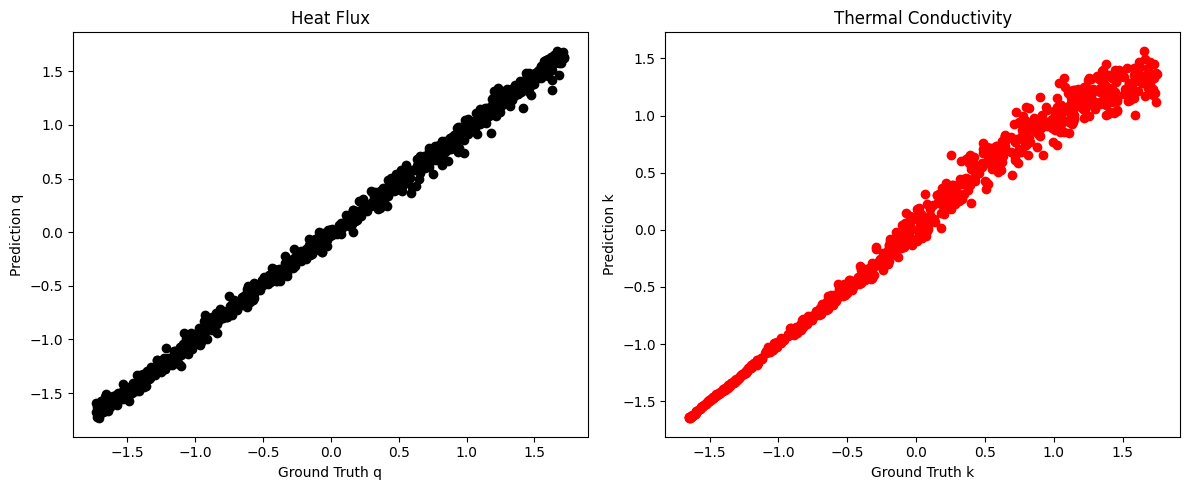

In [64]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

print("\t\t\tMean squared error: %.3f" % mean_squared_error(y_train.iloc[:,0], z_mean[:,0]),"\t\t\t\t\t\t\tMean squared error: %.3f" % mean_squared_error(y_train.iloc[:,1], z_mean[:,1]))
print('\t\t\t2 Variance score: %.3f' % r2_score(y_train.iloc[:,0], z_mean[:,0]), '\t\t\t\t\t\t\tR2 Variance score: %.3f' % r2_score(y_train.iloc[:,1], z_mean[:,1]))
print("________________________________________________________________________")
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# First Scatter Plot (left subplot)
axes[0].scatter(y_train.iloc[:,0], z_mean[:,0], color='black')
axes[0].set_xlabel('Ground Truth q')
axes[0].set_ylabel('Prediction q')
axes[0].set_title('Heat Flux')

# Second Scatter Plot (right subplot)
axes[1].scatter(y_train.iloc[:,1], z_mean[:,1], color='red')  # Assuming you have y_train2 and r_mean2
axes[1].set_xlabel('Ground Truth k')
axes[1].set_ylabel('Prediction k')
axes[1].set_title('Thermal Conductivity')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

## Plotting the results for Test Data

In [65]:
[z_mean_t, z_log_var_t, z_t] = encoder.predict([x_test],batch_size=batch_size)

7/7 [==============================] - 0s 3ms/step


			Mean squared error: 0.003 							Mean squared error: 0.003
			R2 Variance score: 0.996 							R2 Variance score: 0.996
________________________________________________________________________


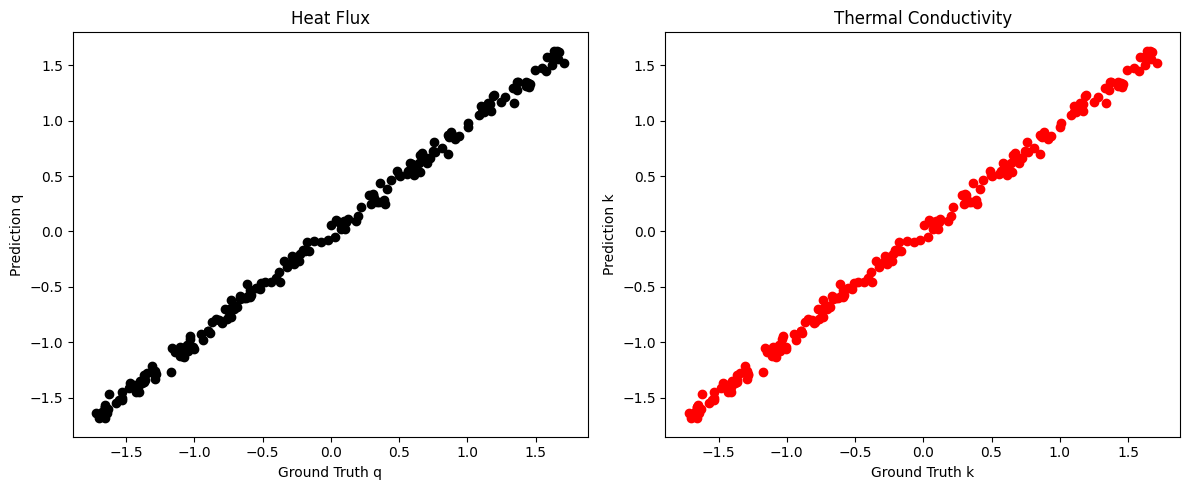

In [66]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

print("\t\t\tMean squared error: %.3f" % mean_squared_error(y_test.iloc[:,0], z_mean_t[:,0]),"\t\t\t\t\t\t\tMean squared error: %.3f" % mean_squared_error(y_test.iloc[:,0], z_mean_t[:,0]))
print('\t\t\tR2 Variance score: %.3f' % r2_score(y_test.iloc[:,0], z_mean_t[:,0]), '\t\t\t\t\t\t\tR2 Variance score: %.3f' % r2_score(y_test.iloc[:,0], z_mean_t[:,0]) )
print("________________________________________________________________________")
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# First Scatter Plot (left subplot)
axes[0].scatter(y_test.iloc[:,0], z_mean_t[:,0], color='black')
axes[0].set_xlabel('Ground Truth q')
axes[0].set_ylabel('Prediction q')
axes[0].set_title('Heat Flux')

# Second Scatter Plot (right subplot)
axes[1].scatter(y_test.iloc[:,0], z_mean_t[:,0], color='red')
axes[1].set_xlabel('Ground Truth k')
axes[1].set_ylabel('Prediction k')
axes[1].set_title('Thermal Conductivity')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

In [67]:
import numpy as np

# Column-wise concatenation for training data
train_combined = np.concatenate([x_train, z_mean, z_log_var], axis=1)

# Column-wise concatenation for testing data
test_combined = np.concatenate([x_test, z_mean_t, z_log_var_t], axis=1)

# Row-wise concatenation of the training and testing data
combined = np.concatenate([train_combined, test_combined], axis=0)

# Assuming 'scaler' was previously fitted to the training data including all features
combined_original = scaler.inverse_transform(combined)

			Mean squared error: 3.141 							Mean squared error: 52.563
			R2 Variance score: 0.996 							R2 Variance score: 0.983
________________________________________________________________________


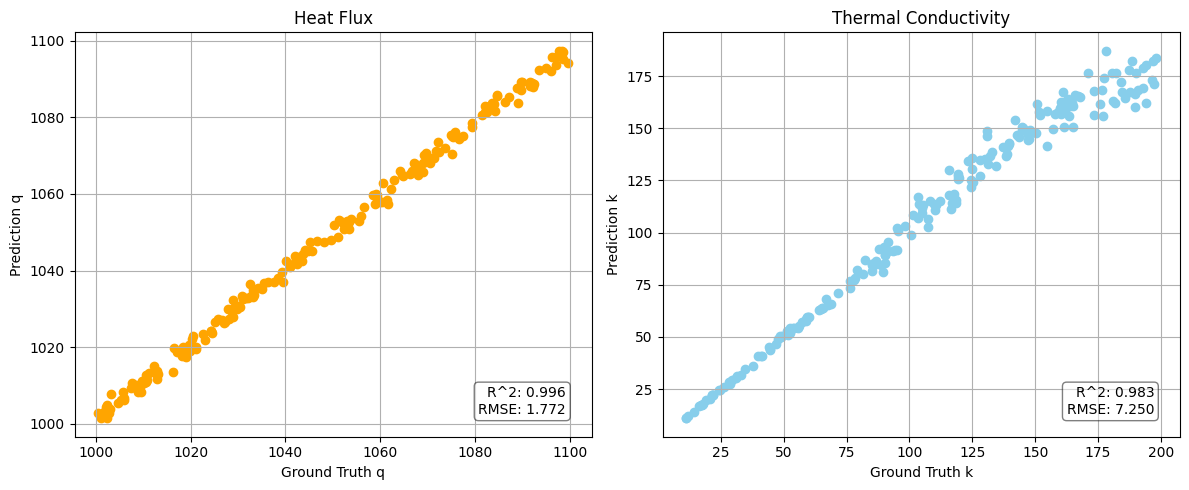

In [69]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Assuming 'data' and 'combined_original' are previously defined pandas DataFrame and numpy array, respectively.

# Calculate RMSE and R2 for q and k
rmse_q = mean_squared_error(data.iloc[:800, -4], combined_original[:800, -4], squared=False)
rmse_k = mean_squared_error(data.iloc[:800, -3], combined_original[:800, -3], squared=False)
r2_q = r2_score(data.iloc[:800, -4], combined_original[:800, -4])
r2_k = r2_score(data.iloc[:800, -3], combined_original[:800, -3])

print("\t\t\tMean squared error: %.3f" % mean_squared_error(data.iloc[:800, -4], combined_original[:800, -4]),
      "\t\t\t\t\t\t\tMean squared error: %.3f" % mean_squared_error(data.iloc[:800, -3], combined_original[:800, -3]))
print('\t\t\tR2 Variance score: %.3f' % r2_q,
      '\t\t\t\t\t\t\tR2 Variance score: %.3f' % r2_k)
print("________________________________________________________________________")

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# First Scatter Plot (left subplot for q)
axes[0].scatter(data.iloc[800:, -4], combined_original[800:, -4], color='orange')
axes[0].set_xlabel('Ground Truth q')
axes[0].set_ylabel('Prediction q')
axes[0].set_title('Heat Flux')
axes[0].grid(True)
# Adding RMSE and R^2 text
axes[0].text(0.95, 0.05, f'R^2: {r2_q:.3f}\nRMSE: {rmse_q:.3f}', verticalalignment='bottom', horizontalalignment='right', transform=axes[0].transAxes, color='black', fontsize=10, bbox=dict(boxstyle="round", facecolor='white', alpha=0.5))

# Second Scatter Plot (right subplot for k)
axes[1].scatter(data.iloc[800:, -3], combined_original[800:, -3], color='skyblue')
axes[1].set_xlabel('Ground Truth k')
axes[1].set_ylabel('Prediction k')
axes[1].set_title('Thermal Conductivity')
axes[1].grid(True)
# Adding RMSE and R^2 text
axes[1].text(0.95, 0.05, f'R^2: {r2_k:.3f}\nRMSE: {rmse_k:.3f}', verticalalignment='bottom', horizontalalignment='right', transform=axes[1].transAxes, color='black', fontsize=10, bbox=dict(boxstyle="round", facecolor='white', alpha=0.5))

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

			Mean squared error: 2.912 							Mean squared error: 63.707
			R2 Variance score: 0.996 							R2 Variance score: 0.978
________________________________________________________________________


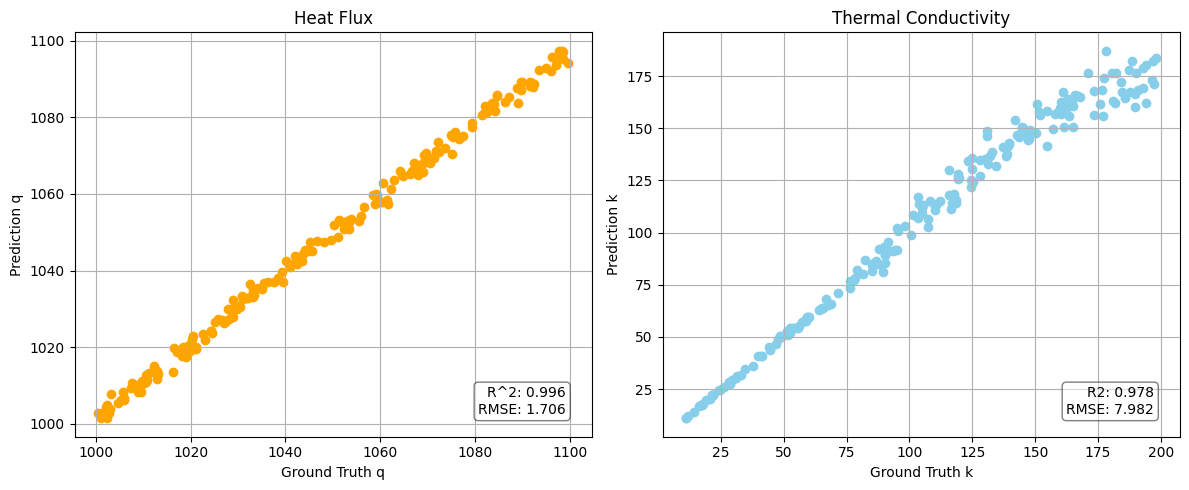

In [70]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Assuming 'data' and 'combined_original' are previously defined pandas DataFrame and numpy array, respectively.

# Calculate RMSE and R2 for q and k
rmse_q = mean_squared_error(data.iloc[800:, -4], combined_original[800:, -4], squared=False)
rmse_k = mean_squared_error(data.iloc[800:, -3], combined_original[800:, -3], squared=False)
r2_q = r2_score(data.iloc[800:, -4], combined_original[800:, -4])
r2_k = r2_score(data.iloc[800:, -3], combined_original[800:, -3])

# Print the metrics
print("\t\t\tMean squared error: %.3f" % mean_squared_error(data.iloc[800:, -4], combined_original[800:, -4]),
      "\t\t\t\t\t\t\tMean squared error: %.3f" % mean_squared_error(data.iloc[800:, -3], combined_original[800:, -3]))
print('\t\t\tR2 Variance score: %.3f' % r2_q,
      '\t\t\t\t\t\t\tR2 Variance score: %.3f' % r2_k)
print("________________________________________________________________________")

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# First Scatter Plot (left subplot for q)
axes[0].scatter(data.iloc[800:, -4], combined_original[800:, -4], color='orange')
axes[0].set_xlabel('Ground Truth q')
axes[0].set_ylabel('Prediction q')
axes[0].set_title('Heat Flux')
axes[0].grid(True)
# Adding RMSE and R^2 text
axes[0].text(0.95, 0.05, f'R^2: {r2_q:.3f}\nRMSE: {rmse_q:.3f}', verticalalignment='bottom', horizontalalignment='right', transform=axes[0].transAxes, color='black', fontsize=10, bbox=dict(boxstyle="round", facecolor='white', alpha=0.5))

# Second Scatter Plot (right subplot for k)
axes[1].scatter(data.iloc[800:, -3], combined_original[800:, -3], color='skyblue')
axes[1].set_xlabel('Ground Truth k')
axes[1].set_ylabel('Prediction k')
axes[1].set_title('Thermal Conductivity')
axes[1].grid(True)
# Adding RMSE and R^2 text
axes[1].text(0.95, 0.05, f'R2: {r2_k:.3f}\nRMSE: {rmse_k:.3f}', verticalalignment='bottom', horizontalalignment='right', transform=axes[1].transAxes, color='black', fontsize=10, bbox=dict(boxstyle="round", facecolor='white', alpha=0.5))

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()